# Pythonopdracht week 5: Pinhole Camera

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Initialization" data-toc-modified-id="Initialization-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Initialization</a></span></li><li><span><a href="#Utilities" data-toc-modified-id="Utilities-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Utilities (some code to be written in this section!)</a></span></li><li><span><a href="#Wireframes:-Transforming-and-Drawing" data-toc-modified-id="Wireframes:-Transforming-and-Drawing-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Wireframes: Transforming and Drawing</a></span></li><li><span><a href="#The-Pinhole-Camera" data-toc-modified-id="The-Pinhole-Camera-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>The Pinhole Camera</a></span></li><li><span><a href="#Camera-Calibration" data-toc-modified-id="Camera-Calibration-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Camera Calibration</a></span></li><li><span><a href="#Augmented-Reality" data-toc-modified-id="Augmented-Reality-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Augmented Reality</a></span><ul class="toc-item"></ul></li><li><span><a href="#From-2D-to-3D" data-toc-modified-id="From-2D-to-3D-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>From 2D to 3D</a></span><ul class="toc-item"></ul></li></ul></div>

## Initialization

In [1]:
import numpy as np
from scipy.linalg import inv
import matplotlib.pyplot as plt
import wget
import cv2
from matplotlib.patches import ConnectionPatch
from matplotlib.collections import LineCollection
from mpl_toolkits.mplot3d.art3d import Line3DCollection
from scipy.linalg import svd

Hidden in this cell are some $\LaTeX$ macros
$\renewcommand{\v}[1]{\mathbf #1}$
$\newcommand{\hv}[1]{\widetilde{\mathbf #1}}$
$\newcommand{\setR}{\mathbb R}$
$\newcommand{\T}{^\top}$
$\newcommand{\inv}{^{-1}}$
$\newcommand{\pfrac}[2]{\frac{\partial #1}{\partial #2}}$

## Utilities

In [2]:
def draw_keypoints(kps, nkps=None, ax=None, marker='x',
                   marker_size=10, scale_and_orientation=True):
    if ax is None:
        ax = plt.gca()
    if nkps is None:
        nkps = len(kps)
    xs = [kp.pt[0] for kp in kps]
    ys = [kp.pt[1] for kp in kps]
    ax.scatter(xs, ys, marker=marker)
    if scale_and_orientation:
        for kp in kps[:nkps]:
            x, y = kp.pt
            r = kp.size / 2
            angle = kp.angle/2/np.pi
            ax.add_artist(plt.Circle((kp.pt), kp.size/2,
                                     color='green', fill=False))
            ax.add_artist(plt.Arrow(x, y, r*np.cos(angle),
                                    r*np.sin(angle), color='red'))



def draw_matches(f1, kps1, f2, kps2, matches,
                 horizontal=True, figsize=(15,15)):
    if horizontal:
        fig, axs = plt.subplots(1,2, figsize=figsize)
    else:
        fig, axs = plt.subplots(2,1, figsize=figsize)

    axs[0].imshow(f1)
    axs[1].imshow(f2)

    # get the indexes of the matches
    idx1 = [m.queryIdx for m in matches]
    idx2 = [m.trainIdx for m in matches]

    xs1 = [kps1[i].pt[0] for i in idx1]
    ys1 = [kps1[i].pt[1] for i in idx1]
    xs2 = [kps2[i].pt[0] for i in idx2]
    ys2 = [kps2[i].pt[1] for i in idx2]


    for x1, y1, x2, y2 in zip(xs1, ys1, xs2, ys2):
        con = ConnectionPatch(xyA=(x1, y1), xyB=(x2, y2), coordsA="data", coordsB="data",
                      axesA=axs[0], axesB=axs[1], color='g')
        axs[1].add_artist(con)


In [3]:
def imshow_row(imttllist, axs=False):
    n = len(imttllist)
    for i, imttl in enumerate(imttllist):
        if imttl is None:
            continue
        im, ttl = imttl
        plt.subplot(1,n,i+1)
        plt.imshow(im, cmap='gray')
        if not axs:
            plt.axis('off')
        plt.title(ttl)

We will also find some use for the ``e2h`` and ``h2e`` functions. We give them to you here.

In [4]:
def e2h(x):
    if len(x.shape) == 1:
        return np.hstack((x, [1]))
    return np.vstack((x, np.ones(x.shape[1])))

def h2e(tx):
    return tx[:-1]/tx[-1]

## Wireframes: Transforming and Drawing

In this lab exercise we will often find the need to define, transform and draw wireframes.

We will define a wireframe as a collection of vertices (points) in 2D or 3D and a collection of edges, each edge linking two of the vertices. The vertices are represented with an array of shape (n,d) (with d the dimension, i.e. 2 or 3). The edges are encoded in an array of shape (m,2) where each row is a pair of integers, say (i, j) linking vertices[i] with vertices[j]. As a simple example: the unit square in 2D:

In [5]:
unit_square = (np.array([[0, 0], [1, 0], [1, 1], [0, 1]]),
               np.array([[0, 1], [1, 2], [2, 3], [3, 0]]))

and the unit cube in 3D:

In [6]:
unit_cube = (np.array([[0, 0, 0], [1, 0, 0], [1, 1, 0], [0, 1, 0],
                       [0, 0, 1], [1, 0, 1], [1, 1, 1], [0, 1, 1]]),
             np.array([[0, 1], [1, 2], [2, 3], [3, 0],
                       [4, 5], [5, 6], [6, 7], [7, 4],
                       [0, 4], [1, 5], [2, 6], [3, 7]]))

and a function to make a drawing of it:

In [7]:
def draw_wireframe(ax, wf, colors='red', lw=2, adapt=True):
    """draw a 2D or 3D wireframe.
    The vertices argument is a (n,2(3)) shaped array where
    each row is a (x,y (,z)) coordinate pair of a vertex and
    edges is (m,2) array where each row is a tuple (i, j)
    indicating that vertex[i] is connected with
    vertex[j] with a straight line"""
    vertices, edges = wf
    segments = np.array([(vertices[i], vertices[j]) for i, j in edges])

    twoD = vertices.shape[1] == 2
    if twoD:
        lines = LineCollection(segments, colors=colors)
        ax.add_artist(lines)

        if adapt:
            # now adjust the xlim and ylim
            # to incorporate the added wireframe
            # (seems mpl doesn't do that automatically)
            # we take the bounding box of the set limits and
            # the new wireframe limits
            vxmn, vymn = np.min(vertices, axis=0)
            vxmx, vymx = np.max(vertices, axis=0)

            axmn, axmx = ax.get_xlim()
            aymn, aymx = ax.get_ylim()

            if aymn > aymx:
                # true when an image is shown
                yaxreversed = True
                aymn, aymx = aymx, aymn
            else:
                yaxreversed = False

            axmn = np.minimum(vxmn, axmn)
            axmx = np.maximum(vxmx, axmx)
            ax.set_xlim(axmn, axmx)

            aymn = np.minimum(vymn, aymn)
            aymx = np.maximum(vymx, aymx)

            if yaxreversed:
                ax.set_ylim(aymx, aymn)
            else:
                ax.set_ylim(aymn, aymx)

    else:
        lines = Line3DCollection(segments, colors=colors)
        ax.add_collection3d(lines)

        if adapt:
            # now adjust the xlim, ylim and zlim
            # to incorporate the added wireframe
            # (seems mpl doesn't do that automatically)
            # we take the bounding box of the set limits and
            # the new wireframe limits
            vxmn, vymn, vzmn = np.min(vertices, axis=0)
            vxmx, vymx, vzmx = np.max(vertices, axis=0)

            axmn, axmx = ax.get_xlim()
            aymn, aymx = ax.get_ylim()
            azmn, azmx = ax.get_zlim()

            axmn = np.minimum(vxmn, axmn)
            axmx = np.maximum(vxmx, axmx)

            ax.set_xlim(axmn, axmx)

            aymn = np.minimum(vymn, aymn)
            aymx = np.maximum(vymx, aymx)

            ax.set_ylim(aymn, aymx)

            azmn = np.minimum(vzmn, azmn)
            azmx = np.maximum(vzmx, azmx)

            ax.set_zlim(azmn, azmx)

            ## Note: there should be a way to do the axis limits settings
            ## independent of the dimension...
    return lines

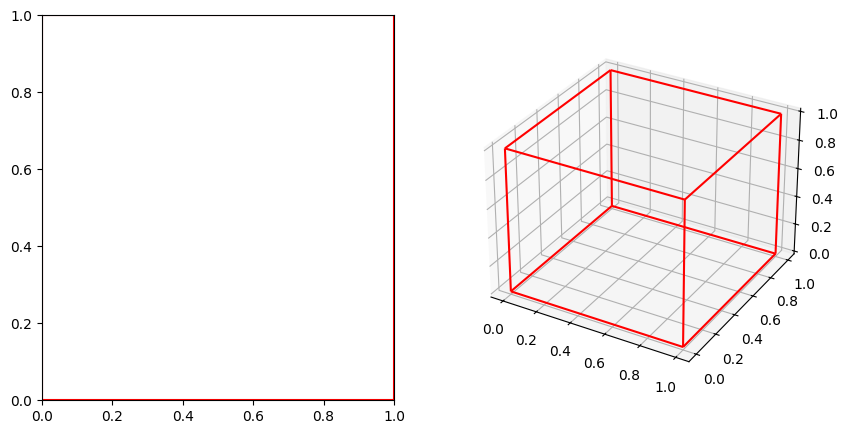

In [8]:
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(121)
draw_wireframe(ax, unit_square)
ax = fig.add_subplot(122, projection='3d')
draw_wireframe(ax, unit_cube);

Unfortunately it is not possible to set the aspect ratio of 3D axes in Matplotlib (only the aspect ratio of the entire figure influences the aspect ratio of the plot).

We can define a 3D rotation by a single vector: the direction of the vector gives the axis of rotation, and the length of the vector can be the angle. Python can do this for us, and we can apply the transformation to the unit cube.

In [9]:
from scipy.spatial.transform import Rotation as R
r = R.from_rotvec(np.pi/2*np.array([1,1,1])/np.sqrt(3))

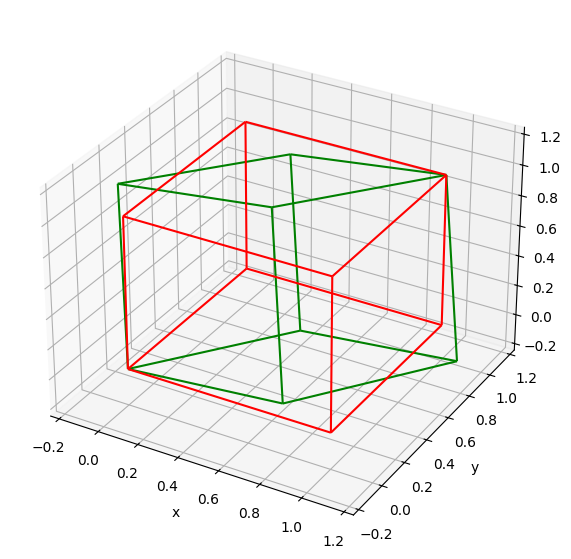

In [10]:
v, e = unit_cube
vr = r.apply(v)
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111, projection='3d')
draw_wireframe(ax, (v,e))
draw_wireframe(ax, (vr,e), colors='green')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z');

### Assignment 3.1

To give our pinhole camera in the next section something more challenging to look at you have to define a house wireframe. Start with the cube and add two vertices at (0.5, 0, 1.5) and (0.5, 1, 1.5) and add the appropriate edges (5 edges extra) to make the shape of a house.

In [11]:
def wireframe_house():
    """
    Return a wireframe (pair of vertices, edges) in the shape of a house:
    add vertices and edges to the cube defined earlier, as described above.

    (Do not get the cube from the global namespace; if you want to use it,
    copy its definition into this function.)
    """
    vertices = np.array([[0, 0, 0], [1, 0, 0], [1, 1, 0], [0, 1, 0],
                         [0, 0, 1], [1, 0, 1], [1, 1, 1], [0, 1, 1],
                         [0.5, 0, 1.5], [0.5, 1, 1.5]])
    edges = np.array([[0, 1], [1, 2], [2, 3], [3, 0],
                      [4, 5], [5, 6], [6, 7], [7, 4],
                      [0, 4], [1, 5], [2, 6], [3, 7],
                      [8, 9], [8, 4], [8, 5], [9, 6],
                      [9, 7]])

    return vertices, edges

In [12]:
house = wireframe_house()
assert len(house) == 2, "`house` should be a tuple of two arrays: one of vertices, one of edges."

assert any(np.array_equal(np.array([0.5, 0., 1.5]), x) for x in house[0]), "At least one roof vertex is missing."
assert any(np.array_equal(np.array([0.5, 1., 1.5]), x) for x in house[0]), "One roof vertex is missing."
assert house[0].shape == (10, 3), "Do you have the right number of vertices in your house?"
assert house[1].shape == (17, 2), "Do you have the right number of edges in your house?"

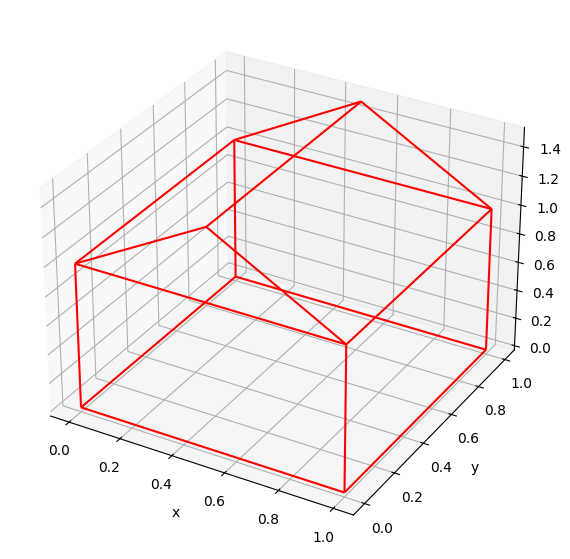

In [13]:
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111, projection='3d')
draw_wireframe(ax, house)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z');

And finally let's make it real Dutch: a row of 3 houses. Not three completely different houses but scaled and translated versions of our 'unit' house. You should position the three houses besides each other in x direction. The first house ``house1`` should start at (0,0,0) with depth (in the y direction) of 1 and height 1.5 (i.e. ``house1`` is ``house``). The second house should start at (1,0,0) but now with width 1.5 and height 2. The third house should be right next to house2 and have width 2 and height 1.2.

The catch is that you may not define new wireframes from scratch. You *have* to use transformations like scaling and translations to obtain the results.

### Assignment 3.2

Implement the following three functions, which are used for scaling and translating wireframes, and applying arbitrary projective transformations.

In [166]:
# Complete all three functions below.
# You should use the transform_3d_wireframe function
# in the scale_3d_wireframe and translate_3d_wireframe functions

def transform_3d_wireframe(wf, A):
    """
    Transform a 3d wireframe with the given projective transformation (matrix) A.

    Note that the ordering of the vertices and edges should be unchanged, only the coordinates of the vertices
    should be transformed.
    """
    return h2e(A @ e2h(np.array(wf[0]).T)).T , wf[1]

def scale_3d_wireframe(wf, sx, sy, sz):
    """
    Scale wireframe wf by factors (sx, sy, sz) in the x, y, z direction respectively.
    """
    return wf[0] * (sx, sy, sz) , wf[1]

def translate_3d_wireframe(wf, tx, ty, tz):
    """
    Translate wireframe wf by distances (tx, ty, tz) in the x, y, z direction respectively.
    """
    return wf[0] + (tx, ty, tz) , wf[1]


In [168]:
# Tests with a very simple wireframe.
test_wf = (np.array([[0, 0, 0], [1, 0, 0]]), np.array([[0, 1]]))

A = np.array([[1., 0., 0., 1.],
             [1., 1., 0., 0.],
             [0., 0., 1., 1.],
             [0., 0., 0., 1.]])

transformed_wf = transform_3d_wireframe(test_wf, A)
assert type(transformed_wf) == tuple and len(transformed_wf) == 2, "The output should again be a wireframe."
assert transformed_wf[0].shape == (2, 3) and transformed_wf[1].shape == (1, 2), \
    "The resulting wireframe should have the same shape."
assert np.array_equal(transformed_wf[1], test_wf[1]), "The incidence relations should be unchanged."
assert np.allclose(transformed_wf[0][0, :], np.array([1., 0., 1.]))

translated_wf = translate_3d_wireframe(test_wf, 1, 2, 3)
assert type(translated_wf) == tuple and len(translated_wf) == 2, "The output should again be a wireframe."
assert translated_wf[0].shape == (2, 3) and translated_wf[1].shape == (1, 2), \
    "The resulting wireframe should have the same shape."
assert np.array_equal(translated_wf[1], test_wf[1]), "The incidence relations should be unchanged."
assert np.allclose(translated_wf[0][0, :], np.array([1, 2, 3]))

scaled_wf = translate_3d_wireframe(translated_wf, 2, 3, 4)
assert type(scaled_wf) == tuple and len(scaled_wf) == 2, "The output should again be a wireframe."
assert scaled_wf[0].shape == (2, 3) and scaled_wf[1].shape == (1, 2), \
    "The resulting wireframe should have the same shape."
assert np.array_equal(translated_wf[1], scaled_wf[1]), "The incidence relations should be unchanged."
assert np.allclose(scaled_wf[0][1, :], np.array([4, 5, 7]))

### Assignment 3.3

Use the functions you have defined above to define the variables `house1`, `house2`, `house3`, as described above.

In [169]:
def three_houses():
    """
    Return wireframes (house1, house2, house3), using scaling and translation of
    the house given by `wireframe_house`. Note that house1 is just equal to the original house.

    The description of the houses is given above.
    """
    house1 = wireframe_house()
    house2 = translate_3d_wireframe(scale_3d_wireframe(wireframe_house(), 1.5, 1, 2/1.5), 1, 0, 0)
    house3 = translate_3d_wireframe(scale_3d_wireframe(wireframe_house(), 2, 1, 1.2/1.5), 2.5, 0, 0)

    return house1, house2, house3


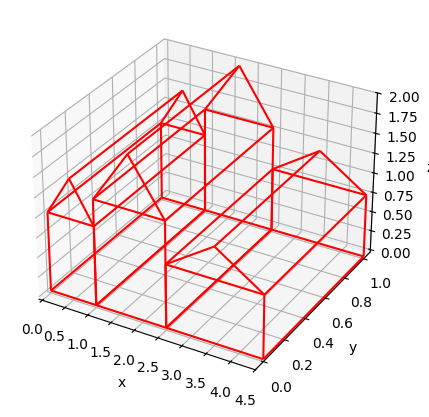

In [170]:
house1, house2, house3 = three_houses()
fig = plt.figure(figsize=(7,5))
ax = fig.add_subplot(111, projection='3d')
draw_wireframe(ax, house1)
draw_wireframe(ax, house2)
draw_wireframe(ax, house3);
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z');


Nice, these 3D drawings, aren't they? But wait, 3D? On a 2D computer screen? That is what the pinhole camera is all about. How to project the 3D world onto a 2D screen (or retina, or camera plane). And that (or a simplification thereof) is what is done in the 3D drawing functions in Matplotlib.

In the next section you will experiment with the pinhole camera model as preparation for the final goal in this lab exercise, namely to estimate the pinhole camera model parameters from real images. So the final goal is different from what is done in computer graphics where the camera matrix is given (selected by the user or programmer).

## The Pinhole Camera

In the lecture notes the pinhole camera was defined with the matrix $P$ mapping 3D coordinates onto a 2D plane:
\begin{align}
\hv x &\sim P\,\hv X
\end{align}
where $\hv x = (x\; y\; 1)\T$ is the homogeneous representation of a 2D point with coordinates $(x,y)$ and $\hv X = (X\; Y\; Z\; 1)\T$ is the homogeneous representation of the 3D point with coordinates $(X,Y,Z)$. Please note the use of $\sim$ where you might have expected $=$.

The camera matrix $P$ can be written as:
\begin{align}
    P = \underbrace{\begin{bmatrix}
    f_x & \gamma & u_0\\
    0 & f_y & v_0\\
    0 & 0 & 1
    \end{bmatrix}}_{P_{}}\,
    \underbrace{\begin{bmatrix}
    R\T & -R\T\v t
    \end{bmatrix}}_{P_{}}
\end{align}

where $R$ is the rotation matrix and $\v t$ the translation that together determine the position of the camera in the 'real world'. Note that the last matrix (the external camera matrix) is in block form, its elementwise shape is $3\times4$.

In this section you have to construct both the internal matrix and external matrix according to geometrical specifications. Then you have to project a 3D wiremodel onto the 2D (retina) plane. 

Remember that a 3D point $\v X_c = (X_c\; Y_c\; Z_c)\T$  with coordinates given with respect to the *camera frame* is projected on the retina as:
\begin{align}
\hv x \sim \begin{bmatrix}
    f_x & \gamma & u_0\\
    0 & f_y & v_0\\
    0 & 0 & 1
    \end{bmatrix} \v X_c
    \end{align}
In the camera frame the $Z$ axis is pointing towards the scene (the optical axis). 

To draw a camera in a scene it is customary in computer graphics and computer vision to draw the *frustum*: a small pyramid with a rectangular 'ground' plane (representing the size of the retina) and the top of the pyramid being the origin of the camera coordinate system. The pyramid indicates the field of view of the camera.

In the examples in these notes we will model a camera with a focal distance of 50 mm. Furthermore we assume the distances on the retina are measured in mm as well (in fact we will measure all distances for now in milimeters) and that the origin of the 2D coordinates on the retina are measured relative to an origin coinciding with the optical axis. Remember that the optical axis is the Z-axis in the camera coordinate system. Lastly we assume a skewless camera. This should be enough information for you to numerically define the internal camera matrix.

### Assignment 4.1

Define the internal camera matrix, as described above.

In [171]:
def get_P_intern(focal_distance=50):
    """
    Return the internal camera matrix (numpy array) for a given focal distance, as
    given by the information above.
    """
    return np.array([
        [focal_distance, 0, 0],
        [0, focal_distance, 0],
        [0, 0, 1]
    ])

To draw the frustum we need to know where the camera is in the world coordinate system. That is why in the ``draw_frustum`` function we need both the internal and external camera matrices.

In [172]:
mnx = -18 # these are the sizes of the 35 mm film in classical camera's
mxx = +18 # still compatible with high end digital camera's
mny = -12
mxy = +12
P_intern = get_P_intern()
P_intern = P_intern/P_intern[2,2]
fl = P_intern[0,0]
frustum = (np.array([[0,0,0], [mnx,mny,fl], [mxx,mny,fl], [mxx,mxy,fl], [mnx,mxy,fl]]),
           np.array([[0,1], [0,2], [0,3], [0,4],
                     [1,2], [2,3], [3,4], [4,1]]))
opt_axis = (np.array([[0, 0, 0], [0, 0, 5*fl]]),
            np.array([[0,1]]))

def draw_frustum(ax, P_intern, P_extern, optax=True, scale=1):
    F = inv(np.vstack((P_extern, np.array([[0,0,0,1]]))))
    sf = scale_3d_wireframe(frustum, scale, scale, scale)
    Fsf = transform_3d_wireframe(sf, F)
    draw_wireframe(ax, Fsf)
    if optax:
        sax = scale_3d_wireframe(opt_axis, scale, scale, scale)
        Fsax = transform_3d_wireframe(sax, F)
        draw_wireframe(ax, Fsax, colors='g')

The code in the cell below should result in a picture like shown below: note the sizes of the 'retina'.
<img src="https://staff.fnwi.uva.nl/r.vandenboomgaard/ComputerVision/_static/frustum_35mm.png"/>

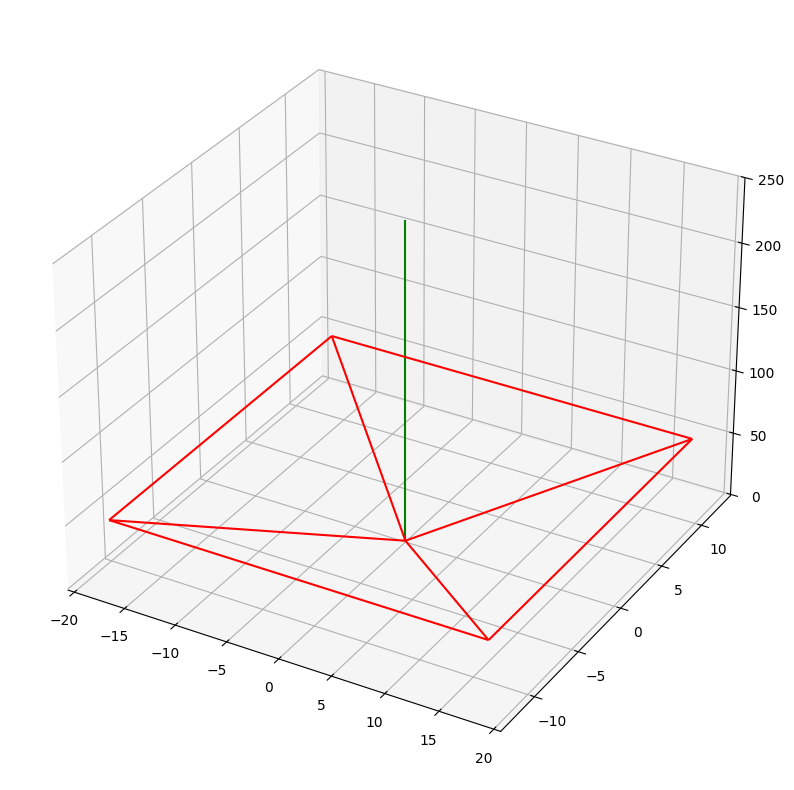

In [173]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')

P_extern = np.column_stack((np.eye(3), np.zeros(3))) # 'identity'
draw_frustum(ax, P_intern, P_extern, scale=1)

In the next cells, we are going to make a more realistic scene with the three houses and one camera. **All measurements are in millimeters.**

1. The camera is at location (0,0,1700) and pointing in the y direction and has focal length 50mm (and no translation internally and skew zero)

1. The front of the houses are at 20000 mm away from the camera (on the ground of course which is at z=0) and the unit house (``house1``) has a square base area of 4000 mm and a height of 6000 mm. The other houses scale up the same.

You have defined P_intern, as well as the three houses. We can scale and translate the houses to fit the requirements. The only thing we still have to define is `P_extern`.

Note that when rotating the 3d world frame such that the z-axis is pointing towards the houses (i.e. in the y direction of the world frame) you can't line up both the x and y axes of the camera frame up with the x and y axes of the world frame. You have to make a choice.

In the code below, the definition of `P_extern`, we expect you to align the y axes of both frames. We will then correct for the inversion of the x axis (that is the consequence of this choice).

The result of your code should be something like

<img src="https://staff.fnwi.uva.nl/r.vandenboomgaard/ComputerVision/_static/scene_cam.png" width="800" />

### Assignment 4.2

Finish the function below, to get the right picture.

In [174]:
def get_P_extern(distance=1700):
    R = np.array([
        [-1, 0, 0],
        [0, 0, 1],
        [0, 1, 0]
    ])

    return np.array([*R, -R @ [0, 0, distance]]).T

[[50  0  0]
 [ 0 50  0]
 [ 0  0  1]] [[   -1     0     0     0]
 [    0     0     1 -1700]
 [    0     1     0     0]]
[[   -50      0      0      0]
 [     0      0     50 -85000]
 [     0      1      0      0]]


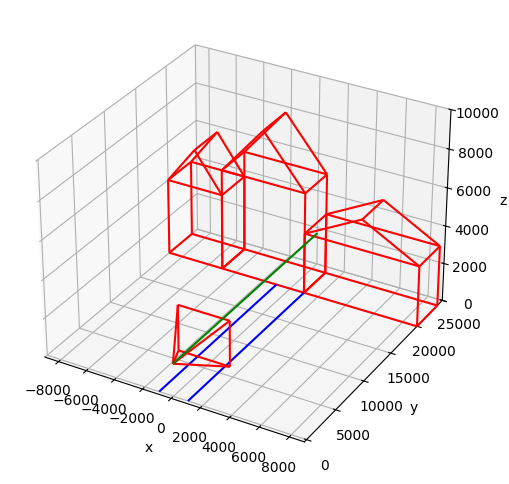

In [175]:
P_intern = get_P_intern()

P_extern = get_P_extern()

print(P_intern, P_extern)
print(P_intern @ P_extern)

house1, house2, house3 = three_houses()

house1mm = scale_3d_wireframe(house1, 4000, 4000, 4000)
house1mm = translate_3d_wireframe(house1mm, -9000, 20000, 0)

house2mm = scale_3d_wireframe(house2, 4000, 4000, 4000)
house2mm = translate_3d_wireframe(house2mm, -9000, 20000, 0)

house3mm = scale_3d_wireframe(house3, 4000, 4000, 4000)
house3mm = translate_3d_wireframe(house3mm, -9000, 20000, 0)

fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111, projection='3d')
draw_frustum(ax, P_intern, P_extern, scale=100) ## large scale needed to see the frustum
draw_wireframe(ax, house1mm)
draw_wireframe(ax, house2mm)
draw_wireframe(ax, house3mm)

lines_to_inf = (np.array([[-1000,0,0], [-1000,20000,0],
                          [1000, 0, 0], [1000, 20000, 0]]),
                np.array([[0,1], [2,3]]))
draw_wireframe(ax, lines_to_inf, colors='b')
ax.set_zlim(0, 10000);
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z');

Now we are in a position to see what the camera 'sees'. The result of the next cell should be something like
<img src="https://staff.fnwi.uva.nl/r.vandenboomgaard/ComputerVision/_static/scene_view1.png" width="800" />

Note the ordering of the houses!

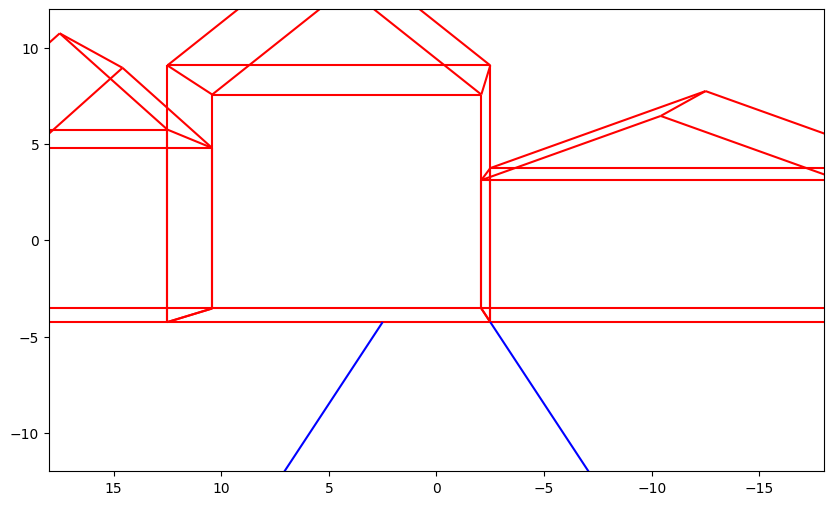

In [176]:
P = P_intern @ P_extern

house1p = transform_3d_wireframe(house1mm, P)
house2p = transform_3d_wireframe(house2mm, P)
house3p = transform_3d_wireframe(house3mm, P)

# note the y-coordinate of the lines start at 1
# (instead of 0 in the previous 3D drawing)
lines_to_inf = (np.array([[-1000, 1,0], [-1000,20000,0],
                          [1000, 1, 0], [1000, 20000, 0]]),
                np.array([[0,1], [2,3]]))

linesp = transform_3d_wireframe(lines_to_inf, P)

fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)
draw_wireframe(ax, house1p)
draw_wireframe(ax, house2p)
draw_wireframe(ax, house3p)

draw_wireframe(ax, linesp, colors='b', adapt=True) # this will enlarge the viewport...

ax.set_xlim(-18, +18) # The standard format for 135 film ('kleinbeeldcamera')
ax.set_ylim(-12, +12) # idem
ax.invert_xaxis() # correction for the x-inversion


In the code below, we redefine `P_extern` to set the camera much further from the houses (i.e. at a negative y coordinate, say $y=-50000$). We leave the other parameters, like the viewport (x and y limits) the same, i.e. the way we have set the axes limits in the previous code block.

As a result, the scene will look almost like an 'affine projection', where we only see the fronts of the houses.

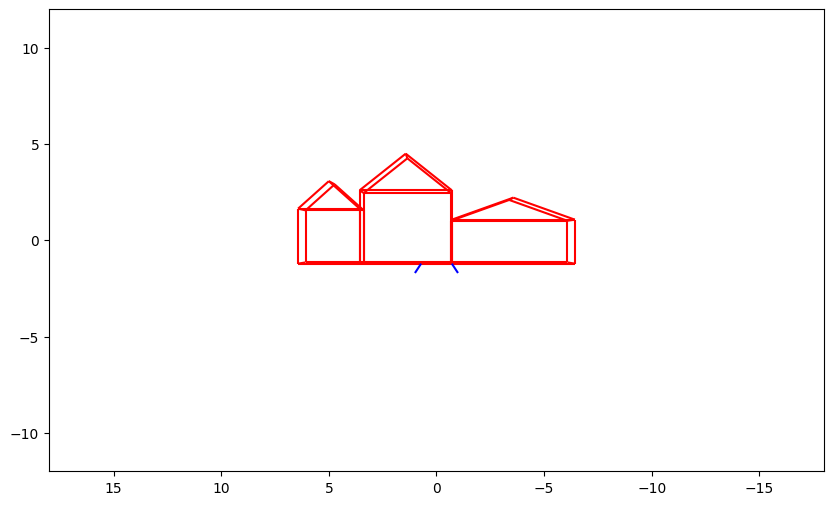

In [177]:
P_extern = np.array([[   -1,     0,     0,     0],
       [    0,     0,     1, -1700],
       [    0,     1,     0, 50000]])

P = P_intern @ P_extern

house1p = transform_3d_wireframe(house1mm, P)
house2p = transform_3d_wireframe(house2mm, P)
house3p = transform_3d_wireframe(house3mm, P)

# note the y-coordinate of the lines start at 1
# (instead of 0 in the previous 3D drawing)
lines_to_inf = (np.array([[-1000, 1,0], [-1000,20000,0],
                          [1000, 1, 0], [1000, 20000, 0]]),
                np.array([[0,1], [2,3]]))

linesp = transform_3d_wireframe(lines_to_inf, P)

fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)
draw_wireframe(ax, house1p)
draw_wireframe(ax, house2p)
draw_wireframe(ax, house3p)

draw_wireframe(ax, linesp, colors='b') # this will enlarge the viewport...

ax.set_xlim(-18, +18) # explicitly set the viewport of the 135 film camera
ax.set_ylim(-12, +12)
ax.invert_xaxis() # and correct for the x axis inversion

## Camera Calibration

The goal of camera calibration is to find the numerical relation
between the three dimensional points and the two dimensional points
where these are projected. Thus we have to find the camera matrix $P$
that projects points $(X,Y,Z)$ (in world coordinates) onto the 2D
points $(x,y)$ in the image:
\begin{align}
   \hv x \sim P \hv X
\end{align}

In the lecture notes it is demonstrated that, given the point correspondences $\hv x_i
\leftrightarrow \hv X_i$ for $i=1,\ldots,n$, we have to solve:
\begin{align}
   \begin{bmatrix}
   \hv X_1\T & \v 0\T & -x_1 \hv X_1\T \\
   \v 0\T & \hv X_1\T & -y_1 \hv X_1\T \\
   \vdots & \vdots & \vdots \\
   \hv X_n\T & \v 0\T & -x_n \hv X_n\T \\
   \v 0\T & \hv X_n\T & -y_n \hv X_n\T \\
   \end{bmatrix}
   \v p = \v 0 \\
   A \v p = \v 0
\end{align}

### Assignment 5.1

To find a null vector of $A$ we can use the same 'SVD trick' that we
have used to find the perspecive transform relating 2D points in one
image with 2D points in another image (now we are relating 3D points
with 2D points).

Given a null vector $\v p$ we can reshape it into the required camera
matrix $P$.

In [ ]:
def calibrate_pinhole_camera(xy, XYZ):
    """
    Use the SVD trick to find the transformation that most closely
    matches the transformation of the points given in XYZ (in 3D
    Euclidean coordinates) to xy (in 2D Euclidean coordinates).
    """
    # YOUR CODE HERE (Replace this and the following line with your code)
    raise NotImplementedError()

To test your calibration function we will use the following image:

In [ ]:
try:
    f = plt.imread('calibrationpoints.jpg')
except FileNotFoundError:
    wget.download('https://staff.fnwi.uva.nl/r.vandenboomgaard/ComputerVision/_images/calibrationpoints.jpg')
    f = plt.imread('calibrationpoints.jpg')
plt.figure(figsize=(10,10))
plt.imshow(f)
plt.tight_layout()

In this image we have marked 18 points in the image these are collected in the array ``xy``. The checker board patterns on the two perpendicular sides of the box depicted in the image allow us to pinpoint these 18 points in 3D coordinates as well (collected in the array ``XYZ``).

In [ ]:
xy = np.array([[ 213.1027,  170.0499], [ 258.1908,  181.3219],
               [ 306.41  ,  193.8464], [ 351.498 ,  183.8268],
               [ 382.8092,  155.6468], [ 411.6155,  130.5978],
               [ 223.7485,  218.2691], [ 267.5841,  230.7935],
               [ 314.5509,  244.5705], [ 357.7603,  235.1771],
               [ 387.819 ,  205.1184], [ 415.3728,  178.1908],
               [ 234.3943,  263.9834], [ 276.9775,  277.1341],
               [ 323.318 ,  291.5372], [ 363.3963,  282.1438],
               [ 392.8288,  251.4589], [ 419.1301,  223.9051]])

XYZ = np.array([[0, -5, 5], [0, -3, 5], [0, -1, 5], [-1, 0, 5],
                [-3, 0, 5], [-5, 0, 5], [0, -5, 3], [0, -3, 3],
                [0, -1, 3], [-1, 0, 3], [-3, 0, 3], [-5, 0, 3],
                [0, -5, 1], [0, -3, 1], [0, -1, 1], [-1, 0, 1],
                [-3, 0, 1], [-5, 0, 1]])

Below we draw the image again and plot the 2D points from array ``xy`` on top of it.

In [ ]:
plt.figure(figsize=(10,10))
plt.imshow(f)
plt.scatter(xy[:,0], xy[:,1], marker='x');

In [ ]:
### Numerical test of calibration function
P = calibrate_pinhole_camera(xy, XYZ)
P = P/P[-1,-1]
assert np.allclose(P, np.array([
    [-2.53380724e+01,  1.76724681e+01, -9.75963068e+00, 3.50812662e+02],
    [ 8.94324977e+00,  1.92571438e+00, -2.83187164e+01, 3.22243837e+02],
    [-2.69423514e-02, -1.94940227e-02, -1.86848368e-02, 1.00000000e+00]]))

In case you pass the numerical test of your calibration function we can do a more insightful test. We take the the 3D points in array ``XYZ`` and project each of the points (the rows) using the camera matrix $P$. Evidently we expect the projected points are close to the points in the ``xy`` matrix.

### Assignment 5.2

Implement the following function, which applies a projection matrix P to an array of points (given in Euclidean coordinates).

In [ ]:
def project_points(P, XYZ):
    # YOUR CODE HERE (Replace this and the following line with your code)
    raise NotImplementedError()

In [ ]:
assert np.allclose(
    project_points(np.column_stack((np.eye(3), np.array([1, 2, 3]))), np.array([[1, 0, 0], [0, 2, 3]])),
    np.array([[2/3, 2/3], [1/6, 2/3]]))

In [ ]:
xy_p = project_points(P, XYZ)
plt.figure(figsize=(10,10))
plt.imshow(f)
plt.scatter(xy[:,0], xy[:,1], marker='x');
plt.scatter(xy_p[:,0], xy_p[:,1], marker='o');

In [ ]:
plt.figure(figsize=(10,10))
plt.imshow(f)
plt.scatter(xy[:,0], xy[:,1], marker='x');
plt.scatter(xy_p[:,0], xy_p[:,1], marker='o');
plt.xlim(200, 400)
plt.ylim(300, 150); # note the 'strange' order: to keep the same orientation

If you did it correctly, the difference between the points in ``xy`` and ``xy_p`` should be barely noticible. A quantative measure is the **reprojection error** as the average of the Euclidean distances between the points in ``xy`` and ``xy_p``.

### Assignment 5.3

Write a function that computes the reprojection error: the average of the Euclidean distances of the vectors in `xy` and the results of their reprojection `xy_p`.

In [ ]:
def reprojection_error(xy, xy_p):
    # YOUR CODE HERE (Replace this and the following line with your code)
    raise NotImplementedError()


In [ ]:
assert np.isclose(reprojection_error(xy, xy_p), 0.42166688)

## Augmented Reality

The image that we have shown in the previous section depicts the real world. Now that we are able to calculate the camera matrix $P$ relating 3D coordinates to the image coordinates we can use computer graphic techniques to draw computer generated images of objects into the scene depicted in the image. In this exercise we keep things simple: the only objects we will draw are wireframe models. For more convincing and lifelike augmented reality we refer to a computer graphics course.

For instance, we can take the unit cube and draw it in the scene (i.e. on top of the image) at the origin of the 3D coordinate frame. This should result in something like this:
<img src="https://staff.fnwi.uva.nl/r.vandenboomgaard/ComputerVision/_static/drawcubeorigin.png" width="600" />

With the functions you have implemented, together with the draw_wireframe function from before, it is be easy to place cubes on top of this image.

In [ ]:
def draw_cube(ax, P, X, Y, Z):
    cube_at_XYZ = translate_3d_wireframe(unit_cube, X, Y, Z)
    cube_p = transform_3d_wireframe(cube_at_XYZ, P)
    draw_wireframe(ax, cube_p)


In [ ]:
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)
ax.imshow(f)
draw_cube(ax, P, 0, 0, 0)
draw_cube(ax, P, 0, -7, 6)
draw_cube(ax, P, -4, 0, 3)

### (Bonus) Animation (3pt)

**Note:** before you start working on the this bonus exercise there is one more exercise section right after this one.

The bonus for this lab exercise is to take the calibration and image done in the previous section and make an animation of a cube moving along a 3D circle $x^2+y^2=r^2$ and $z=0$ (i.e. as if it shifts over the table surface).

To complete this bonus exercise, upload your animation in a format most video players will be able to handle, and hand it in together with the notebook.

## From 2D to 3D

The camera matrix $P$ maps 3D points in world coordinates onto 2D coordinates in camera coordinates. Be sure to understand that this mapping is **not invertible.** Does that mean that we cannot reconstruct the 3D world from (one or more) 2D images? O yes we can!

In general we need more than one image from the same scene taken from different viewpoints. A bit like the brain is able to reconstruct 3D space by looking with two eyes (To illustrate the need for two eyes, stretch you arms forwards in front of you but not extended completely, start with your hands far away from eachother. Point your index fingers of both hands towards eachother and **while having one eye closed** bring your hands together in a smooth movement and let the tops of two index fingers meet. Not many people succeed.) Looking with two eyes is called stereo vision and is an important subject in Computer Vision.

But even given only one image we can do some sort of 3D reconstruction. Instead of a second eye you could project a pattern on the objects in the scene and then you can reconstruct the 3D positions of the pattern points seen in the image. This is a very simplified view of how the Kinect camera works.

Even more simple solutions are practical in some situations. For instance if there is knowledge on which 3D plane a 2D point (x,y) lies you can reconstruct the 3D position (X,Y,Z) given the camera matrix $P$.

A plane in 3D space can be represented as:
\begin{align}
a X + b Y + c Z + d = 0
\end{align}
Using homogeneous coordinates we can write:
\begin{align}
\begin{bmatrix}a & b & c & d\end{bmatrix}\,
\begin{bmatrix}X \\ Y \\ Z\\ 1\end{bmatrix} = 0
\end{align}
or
\begin{align}
\hv N\T\, \hv X = 0
\end{align}

So the assumption is we know the plane $\hv p$, but we are also given a 2D point that is the projection $\hv x \sim P\,\hv X$ of a 3D point $\hv X$ on the plane $\hv N$. Summarizing we know:
\begin{align}
\hv N\T\, \hv X &= 0\\
\hv x &\sim P\,\hv X
\end{align}
where $\hv X$ is the only unknown.

### Assignment 7.1

In ANS question 3(a), you are asked to algebraically solve the system above to obtain a way to calculate $\tilde {\bf X}$. Implement your solution (in case you need more than a few lines of code, your mathematical solution is possibly wrong; think again or ask for help).

In [ ]:
def reconstruct(tN, P, tx):
    # YOUR CODE HERE (Replace this and the following line with your code)
    raise NotImplementedError()

and test your solution on a few points in the ground plane for which the (X,Y,Z) coordinates are known:

In [ ]:
XYZgp = np.array([[0,0,0],
                  [-2,0,0],
                  [-5,0,0],
                  [0,-2,0],
                  [0,-5,0]])
xygp = np.array([[352, 323],
                 [382, 290],
                 [423, 245],
                 [304, 307],
                 [239, 286]])
tN = np.array([0, 0, 1, 0])
P = np.array([[-2.53380724e+01,  1.76724681e+01, -9.75963068e+00, 3.50812662e+02],
    [ 8.94324977e+00,  1.92571438e+00, -2.83187164e+01, 3.22243837e+02],
    [-2.69423514e-02, -1.94940227e-02, -1.86848368e-02, 1.00000000e+00]])
XYZgprec = np.array([reconstruct(tN, P, e2h(xy)) for xy in xygp])
print(XYZgprec)

If all went well you will see that XYZgp is about the same as XYZgprec. In that case the reconstruct function works as expected.

### (Bonus) The Big Box (0pt, just for fun)

Consider the calibrated image again where 4 corners of the toy box are indicated. Three of them are on the ground plane, the last one is not and you need to use another plane to reconstruct this point.

In [ ]:
plt.figure(figsize=(10,10))
plt.imshow(f)
xy_boxcorners = np.array([[55, 222],
                          [351, 321],
                          [527, 121],
                          [314, 69]])
plt.scatter(xy_boxcorners[:,0], xy_boxcorners[:,1], marker='x', s=100, c="red");

It is your task to do the reconstruction and use the resulting 3D points to define a 3D wireframe that describes the entire toy box (you may assume that the box is a rectangular one, all angles are 90 degrees). Then use the camera matrix $P$ to project the wireframe and plot it on top of this image.

In [ ]:
# YOUR CODE HERE (Replace this and the following line with your code)
raise NotImplementedError()

If you are really in to it you might want to reproduce the following image showing the reconstruction of (part of) the horizon. Note that all lines are calculated just from the 4 3D points and the projection matrix $P$.
<img src="https://staff.fnwi.uva.nl/r.vandenboomgaard/ComputerVision/_static/box_horizon.png" width="800" />

The green box is the box that you have to draw in the previous bonus exercise.

In [ ]:
# YOUR CODE HERE (Replace this and the following line with your code)
raise NotImplementedError()